## This notebook is to automatically measure reciprocal space pixel size for SEND and to measure the affine transform needed to correct for diffraction roundness

- We assume au-xgrating sample is being used 

- We assume 256*256 scans are collected

In [1]:
settings = {
    "data_label": 'bxflow_test/20220920_115349',
    "align_BF": '1',
    "write_to_file": '1'
}

In [2]:
%matplotlib notebook
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
import hyperspy.api as hs
import os
import pyxem as pxm
import py4DSTEM
import logging
from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

In [3]:
path = '/dls/e02/data/2022/cm31101-4/processing/Merlin/'
data_label = settings['data_label']
timestamp = data_label.split('/')[-1]
ibf_path = f'{path}/{data_label}/{timestamp}_ibf.hspy'
meta_path = f'{path}/{data_label}/{timestamp}.hdf'
full_path = f'{path}/{data_label}/{timestamp}_data.hdf5'

In [4]:
save_path = os.path.dirname(ibf_path)
print(save_path)
base_name = os.path.dirname(save_path)
print(base_name)
print(os.getcwd())

/dls/e02/data/2022/cm31101-4/processing/Merlin//bxflow_test/20220920_115349
/dls/e02/data/2022/cm31101-4/processing/Merlin//bxflow_test
/dls/science/groups/e02/Mohsen/code/jupyterhub_active/bxflow_test_notebooks


In [5]:
im = hs.load(ibf_path)
with h5py.File(meta_path, 'r') as f:
    print(f['metadata'].keys())
    print(f['metadata/magnification'][()])
    mag = f['metadata/magnification'][()]
    print(f['metadata/field_of_view(m)'][()])
    fov = f['metadata/field_of_view(m)'][()]
    sh = f['metadata/4D_shape'][()]
    print(f['metadata/aperture_size'][()])
    print(f['metadata/nominal_camera_length(m)'][()])
    print(f['data/mask'].shape)
    mask = f['data/mask'][()]


<KeysViewHDF5 ['4D_shape', 'A1_value_(kV)', 'A2_value_(kV)', 'aperture_size', 'convergence_semi-angle(rad)', 'current_OLfine', 'deflector_values', 'defocus(nm)', 'defocus_per_bit(nm)', 'field_of_view(m)', 'ht_value(V)', 'lens_values', 'magnification', 'merlin_camera_length(m)', 'nominal_camera_length(m)', 'nominal_scan_rotation', 'set_bit_depth', 'set_dwell_time(usec)', 'set_scan_px', 'spot_size', 'step_size(m)', 'x_pos(m)', 'x_tilt(deg)', 'y_pos(m)', 'y_tilt(deg)', 'z_pos(m)', 'zero_OLfine']>
60000
3.3333333333333333e-06
4
0.2
(515, 515)


<KeysViewHDF5 ['data']>


<IPython.core.display.Javascript object>


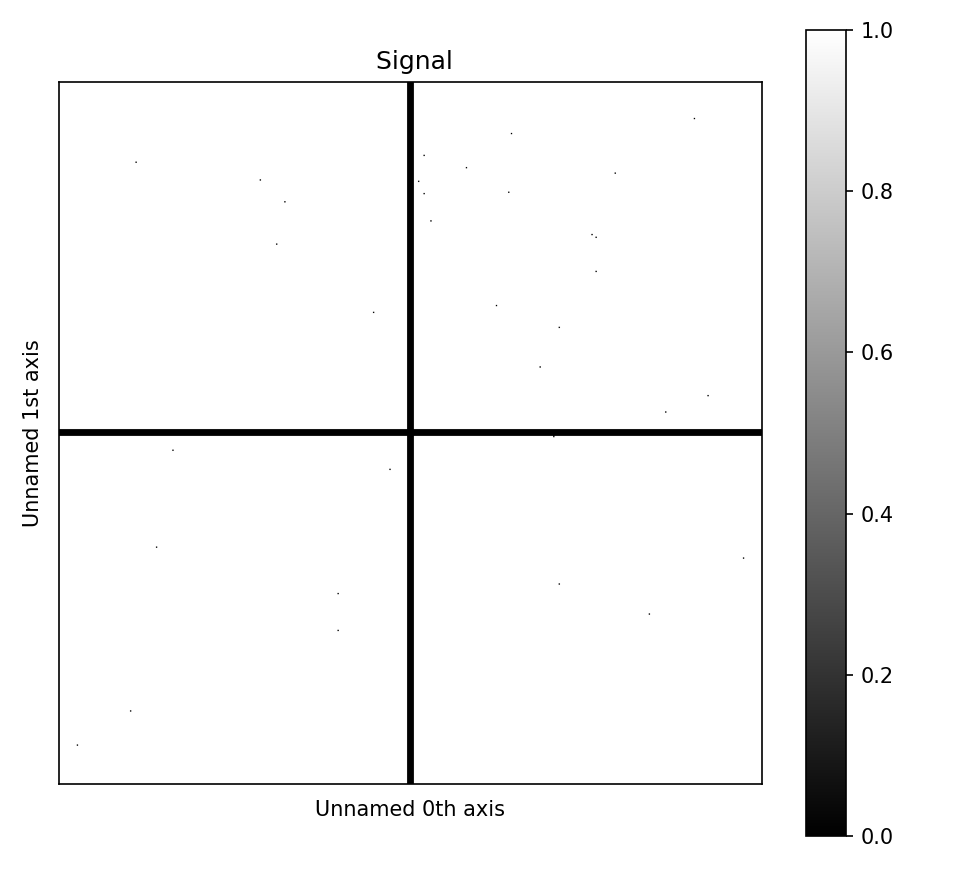

In [6]:
# This should not be needed in future with updated mask
with h5py.File('/dls_sw/e02/medipix_mask/Merlin_12bit_mask.h5', 'r') as f:
    print(f.keys())
    mask = f['data/mask'][()]
mask = mask.astype('bool')
mask = hs.signals.Signal2D(mask)
mask.plot()

In [7]:
d = hs.load(full_path)
d.axes_manager[2].offset = 0.
d.axes_manager[3].offset = 0.
d.axes_manager[2].scale = 1
d.axes_manager[3].scale = 1
d_mask = d * mask

In [58]:
# This can be removed once py4DSTEM gets updated in env
import numpy as np
from py4DSTEM.process.utils import get_CoM
def get_probe_size(DP, thresh_lower=0.01, thresh_upper=0.99, N=100):
    """
    Gets the center and radius of the probe in the diffraction plane.
    The algorithm is as follows:
    First, create a series of N binary masks, by thresholding the diffraction pattern
    DP with a linspace of N thresholds from thresh_lower to thresh_upper, measured
    relative to the maximum intensity in DP.
    Using the area of each binary mask, calculate the radius r of a circular probe.
    Because the central disk is typically very intense relative to the rest of the DP, r
    should change very little over a wide range of intermediate values of the threshold.
    The range in which r is trustworthy is found by taking the derivative of r(thresh)
    and finding identifying where it is small.  The radius is taken to be the mean of
    these r values. Using the threshold corresponding to this r, a mask is created and
    the CoM of the DP times this mask it taken.  This is taken to be the origin x0,y0.
    Args:
        DP (2D array): the diffraction pattern in which to find the central disk.
            A position averaged, or shift-corrected and averaged, DP works best.
        thresh_lower (float, 0 to 1): the lower limit of threshold values
        thresh_upper (float, 0 to 1): the upper limit of threshold values
        N (int): the number of thresholds / masks to use
    Returns:
        (3-tuple): A 3-tuple containing:
            * **r**: *(float)* the central disk radius, in pixels
            * **x0**: *(float)* the x position of the central disk center
            * **y0**: *(float)* the y position of the central disk center
    """
    thresh_vals = np.linspace(thresh_lower, thresh_upper, N)
    r_vals = np.zeros(N)

    # Get r for each mask
    DPmax = np.max(DP)
    for i in range(len(thresh_vals)):
        thresh = thresh_vals[i]
        mask = DP > DPmax * thresh
        r_vals[i] = np.sqrt(np.sum(mask) / np.pi)

    # Get derivative and determine trustworthy r-values
    dr_dtheta = np.gradient(r_vals)
    mask = (dr_dtheta <= 0) * (dr_dtheta >= 2 * np.median(dr_dtheta))
    r = np.mean(r_vals[mask])

    # Get origin
    thresh = np.mean(thresh_vals[mask])
    mask = DP > DPmax * thresh
    x0, y0 = get_CoM(DP * mask)
    
    return r, x0, y0

Finding origins: 100%|██████████| 65.0k/65.0k [28:42<00:00, 37.8DP/s]


<IPython.core.display.Javascript object>


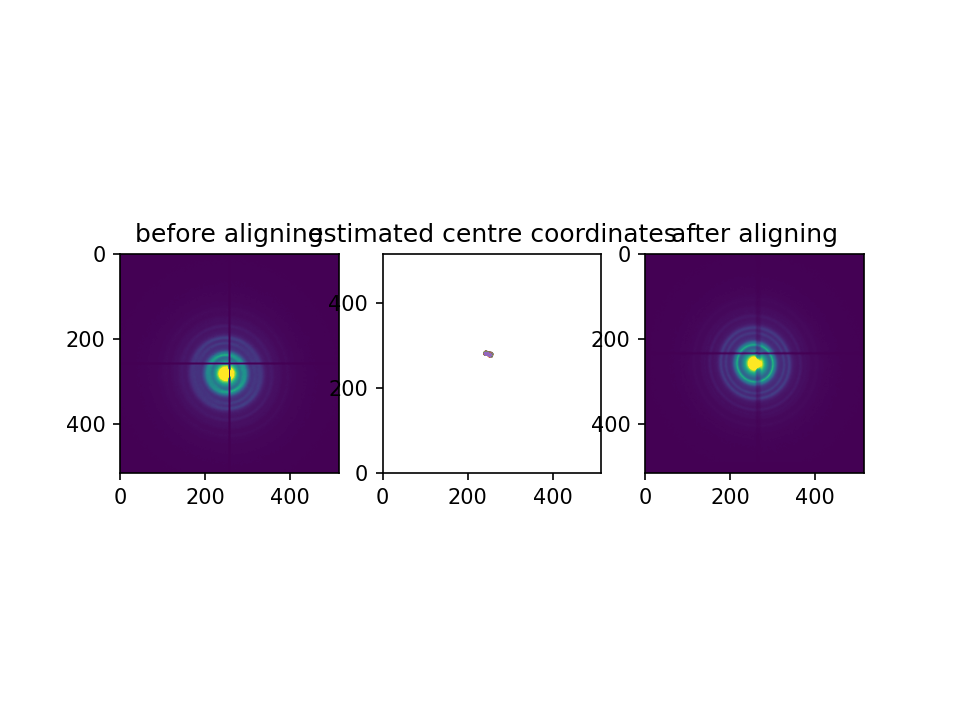

In [8]:
if settings['align_BF']=='1':
    # shift function
    logging.info("Aligning the BF disc in the data.")
    d_before = d_mask.mean()
    from scipy import ndimage
    def shift_image(im, shift=0, interpolation_order=1, fill_value=0):
        if not np.any(shift):
            return im
        else:
            fractional, integral = np.modf(shift)
            if fractional.any():
                order = interpolation_order
            else:
                # Disable interpolation
                order = 0
            return ndimage.shift(im, shift, cval=fill_value, order=order)
    # Getting the origin coordinates
    data = py4DSTEM.io.DataCube(d_mask.data)
    
    # find good value for r for arbitrary data
    rad, x0, y0 = get_probe_size(data.data[0,0,:,:])
    print('BF disc radius in pixels:', int(rad))
    # Here rad is radius of BF disc
    
    origins = py4DSTEM.process.calibration.origin.get_origin(data, r = int(2*rad)+1) 
    cent_coords = list(origins)
    cent_coords = np.asarray(cent_coords)
    
    # expressing them as shift values
    cent_coords = cent_coords.reshape(2, d.data.shape[0]*d.data.shape[1])
    shifts = -1 * (cent_coords - 515 // 2)
    
    # Apply the above shifts
    data_resh = np.reshape(data.data, (d.data.shape[0]*d.data.shape[1],515,515))
    for i in range(data_resh.shape[0]):
        data_resh[i,:,:] = shift_image(data_resh[i,:,:], shift= [shifts[0][i], shifts[1][i]])
        
    # replacing d_mask here
    d_mask = pxm.signals.ElectronDiffraction2D(np.reshape(data_resh, (d.data.shape[0],d.data.shape[1],515,515)))
    d_mean = d_mask.mean()
    #Plotting mean signal with the estimate of the centre positions
    fig, axs = plt.subplots(1,3)
    axs[0].imshow(np.log10(1 + d_before.data), vmax=0.4)
    axs[0].set_title('before align')
    axs[1].plot(origins[1], origins[0])
    axs[1].set_xlim([0,515])
    axs[1].set_ylim([0,515])
    axs[1].set_aspect(1)
    axs[1].invert_yaxis()
    axs[1].set_title('estimated centre pos')
    axs[2].imshow(np.log10(1 + d_mean.data), vmax=0.4)
    axs[2].set_title('after align')
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(f'{os.getcwd()}/aligning_BF_disc.png')
    
else:
    logging.info("No BF disc alignment performed.")
    d_mean = d_mask.mean()
    fig, axs = plt.subplots(1,1)
    axs[0].imshow(np.log10(1 + d_mean.data), vmax=0.1)
    axs[0].set_title('without aligning')
    plt.savefig(f'{os.getcwd()}/without_BF_disc_alignment.png')

In [35]:
cal_lib = CalibrationDataLibrary(au_x_grating_dp=d_mean)
cal = CalibrationGenerator(diffraction_pattern=d_mean)

In [36]:
cal.get_elliptical_distortion(mask_radius=int(2*rad)+1,
                              scale=100, amplitude=np.max(d_mean.data),
                              asymmetry=0.9,spread=2)

array([[ 0.98706516, -0.01571627,  0.        ],
       [-0.01571627,  0.9809042 ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

[########################################] | 100% Completed |  0.1s


/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/diffsims/utils/ring_pattern_utils.py:102: RuntimeWarning: divide by zero encountered in power
  v.append(direct_beam_amplitude * Ri ** -2)  # np.exp((-1*(Ri)*(Ri))/d0)


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


<IPython.core.display.Javascript object>


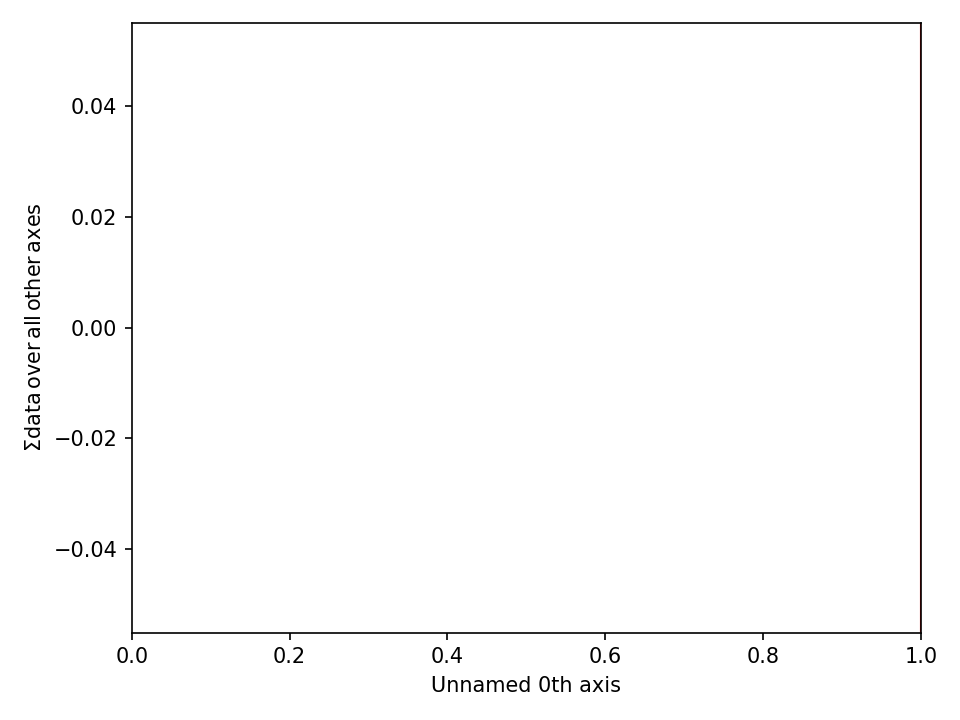

<IPython.core.display.Javascript object>


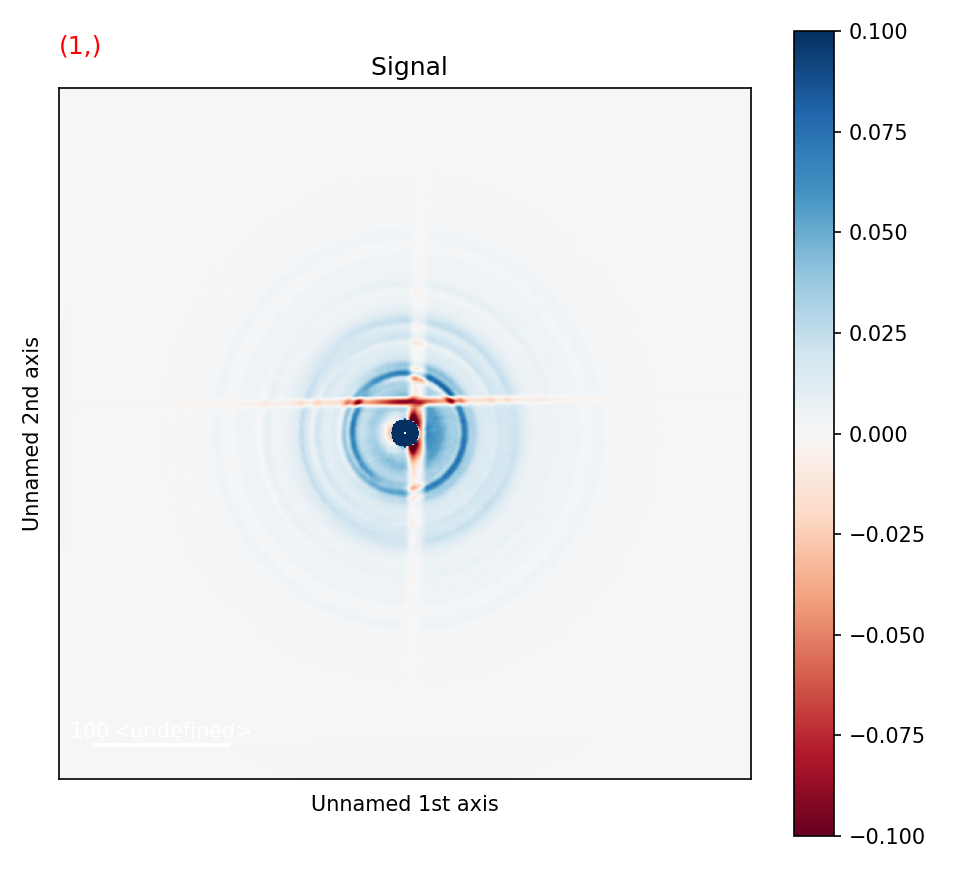

In [37]:
residuals = cal.get_distortion_residuals(mask_radius=int(2*rad)+1, spread=2)
residuals.plot(cmap='RdBu', vmax=20)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


<IPython.core.display.Javascript object>


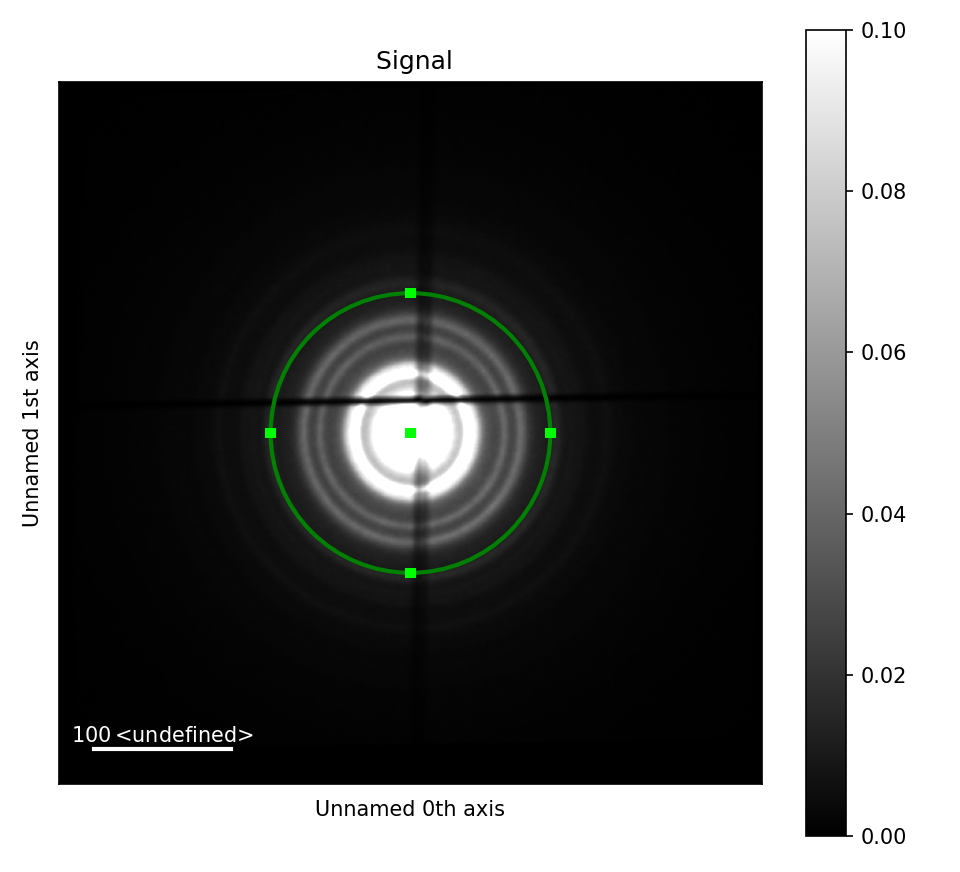

In [38]:
cal.plot_corrected_diffraction_pattern(vmax=0.1)

In [55]:
fig = plt.gcf()
fig.savefig(f'{os.getcwd()}/After_affine_correction.png')

In [44]:
affine_matrix = cal.affine_matrix
print(affine_matrix)

[[ 0.98706516 -0.01571627  0.        ]
 [-0.01571627  0.9809042   0.        ]
 [ 0.          0.          1.        ]]


In [41]:
recip_pix = cal.get_diffraction_calibration(mask_length=30,
                                linewidth=5)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [42]:
recip_pix

0.010126373241571882

In [46]:
cal_dict = {}
cal_dict['reciprocal_space_pix(1/A)'] = recip_pix
cal_dict['affine_transform'] = affine_matrix.tolist()

# Check if write_to_file flag is on if so write to root, otherwise write in cwd

if settings['write_to_file']=='1':
    with open(os.path.join(base_name, 'calibrations_diff.json'), 'w') as fp:
        json.dump(cal_dict, fp)
    
else:
    with open(os.path.join(os.getcwd(), 'calibrations_diff.json'), 'w') as fp:
        json.dump(cal_dict, fp)